In [1]:
import torchvision
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch
import torch.nn as nn
from torchinfo import summary
import torch.nn.functional as F
import seaborn as sns
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score,recall_score,f1_score


In [2]:
transform = transforms.Compose([ 
    transforms.Grayscale(),  
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)) 
])

In [3]:
from medmnist import OCTMNIST
octmnist = OCTMNIST(root='./data', split='train', download=True, transform=transform)


Using downloaded and verified file: ./data/octmnist.npz


In [27]:
octmnist2 = OCTMNIST(root='./data',split='test', download=True)

Using downloaded and verified file: ./data/octmnist.npz


In [4]:
total_length = len(octmnist)
train_length = int(0.7 * total_length)
val_length = int(0.15 * total_length)
test_length = total_length - train_length - val_length

batch_size = 64
# data_loader = torch.utils.data.DataLoader(octmnist, batch_size=batch_size, shuffle=True)
# Split the dataset
train_set, val_set, test_set = random_split(
    dataset=octmnist,
    lengths=[train_length, val_length, test_length],
    generator=torch.Generator().manual_seed(7)
)
# Apply transforms and create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [5]:

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def summary(self):
        return summary(model)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = cnn()
model.to(device)


cnn(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [6]:
model.summary()

Layer (type:depth-idx)                   Param #
cnn                                      --
├─Conv2d: 1-1                            320
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Linear: 1-4                            803,072
├─Linear: 1-5                            32,896
├─Linear: 1-6                            516
Total params: 855,300
Trainable params: 855,300
Non-trainable params: 0

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:

# train_los, val_los = [], []
# train_acc, val_acc= [], []

# for epoch in range(20):
#     model.train()
#     run_loss = 0.0
#     correct = 0
#     total = 0

#     for images, classes in train_loader:
#         # images, classes = images.to(device), classes.to(device)
#         classes = classes.squeeze(1)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, classes)
#         loss.backward()
#         optimizer.step()

#         run_loss = run_loss+loss.item()
#         k, predicted = torch.max(outputs.data, 1)
#         total = total+ classes.size(0)
#         correct =correct+ (predicted == classes).sum().item()

#     train_los.append(run_loss / len(train_loader))
#     train_acc.append((correct / total)*100)

In [9]:
def print_confusion_matrix(true_test, test_predicted):
    matrix = confusion_matrix(true_test, test_predicted)
    plt.figure(figsize=(16,14))
    sns.heatmap(matrix, annot=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def print_accuracy_plot(train_accuracies, val_accuracies, accuracy_test, num_epochs=3):
    plt.figure(figsize=(8,6))
    epochs_range = range(1, num_epochs + 1)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
    plt.axhline(y=accuracy_test, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('No of Epochs')
    plt.ylabel('Accuracies')
    plt.title('Accuracies for Train, Test and Validation')
    plt.legend()
    plt.show()

def print_losses_plot(train_losses, val_losses, test_loss, num_epochs=3):
    plt.figure(figsize=(8,6))
    epochs_range = range(1, num_epochs + 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('No of Epochs')
    plt.ylabel('Losses')
    plt.title('Plot: Train, Test and Validation Losses')
    plt.legend()
    plt.show()

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=2):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        total_val = 0
        correct_val = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy =  100 * correct_train / total_train
        # print("TRAIIIIN", train_accuracy)
        train_accuracies.append(train_accuracy)
        # Validation loss
        model.eval()
        val_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze(1)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            _, predicted_val = torch.max(outputs, 1)
            correct_val += (predicted_val == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy}\tValidation Accuracy: {val_accuracy}')

    return train_losses, val_losses, train_accuracies, val_accuracies

train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1/10, Training Loss: 0.6918, Validation Loss: 0.4767
Train Accuracy: 74.54310963903097	Validation Accuracy: 83.1817249162164
Epoch 2/10, Training Loss: 0.4689, Validation Loss: 0.4124
Train Accuracy: 83.59298286752744	Validation Accuracy: 85.92435537924902
Epoch 3/10, Training Loss: 0.4056, Validation Loss: 0.4028
Train Accuracy: 85.934958158076	Validation Accuracy: 85.76020792011491
Epoch 4/10, Training Loss: 0.3639, Validation Loss: 0.3437
Train Accuracy: 87.15724063136605	Validation Accuracy: 87.8667669790028
Epoch 5/10, Training Loss: 0.3329, Validation Loss: 0.3334
Train Accuracy: 88.29305468028666	Validation Accuracy: 88.45496204090007
Epoch 6/10, Training Loss: 0.3018, Validation Loss: 0.3188
Train Accuracy: 89.35852153649994	Validation Accuracy: 88.68750427467342
Epoch 7/10, Training Loss: 0.2749, Validation Loss: 0.3196
Train Accuracy: 90.40053932847742	Validation Accuracy: 89.09787292250871
Epoch 8/10, Training Loss: 0.2524, Validation Loss: 0.2993
Train Accuracy: 91.08

In [11]:
test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)
        outputs = model(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item() 

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_mat = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_mat)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Accuracy:  89.22929631402585
Confusion Matrix:  [[4734   68  146   61]
 [  86 1342   32  109]
 [ 211   37  572  398]
 [ 116   85  226 6400]]
Precision:  82.50720673942583
Recall:  80.18743101843393
F1 Score:  81.17696302486226


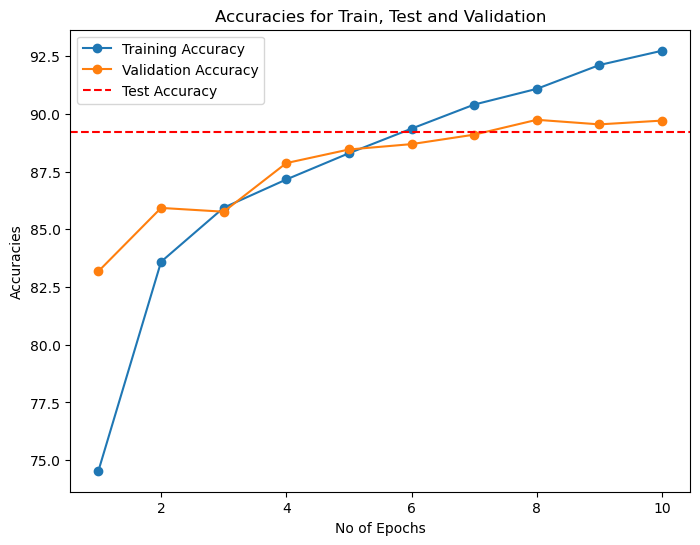

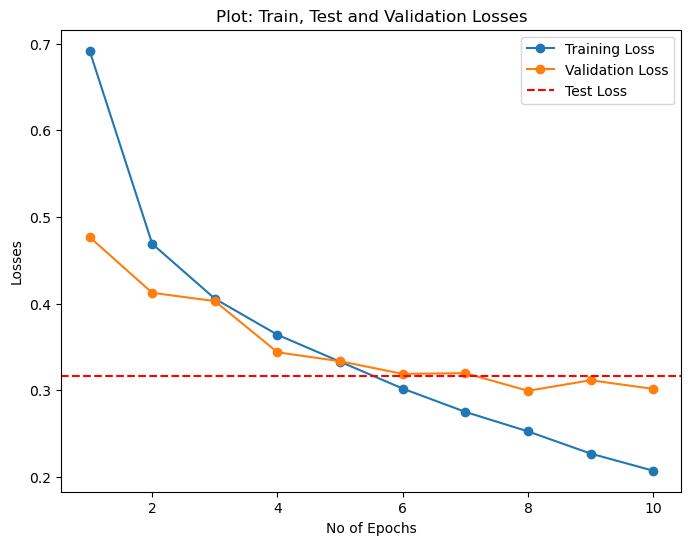

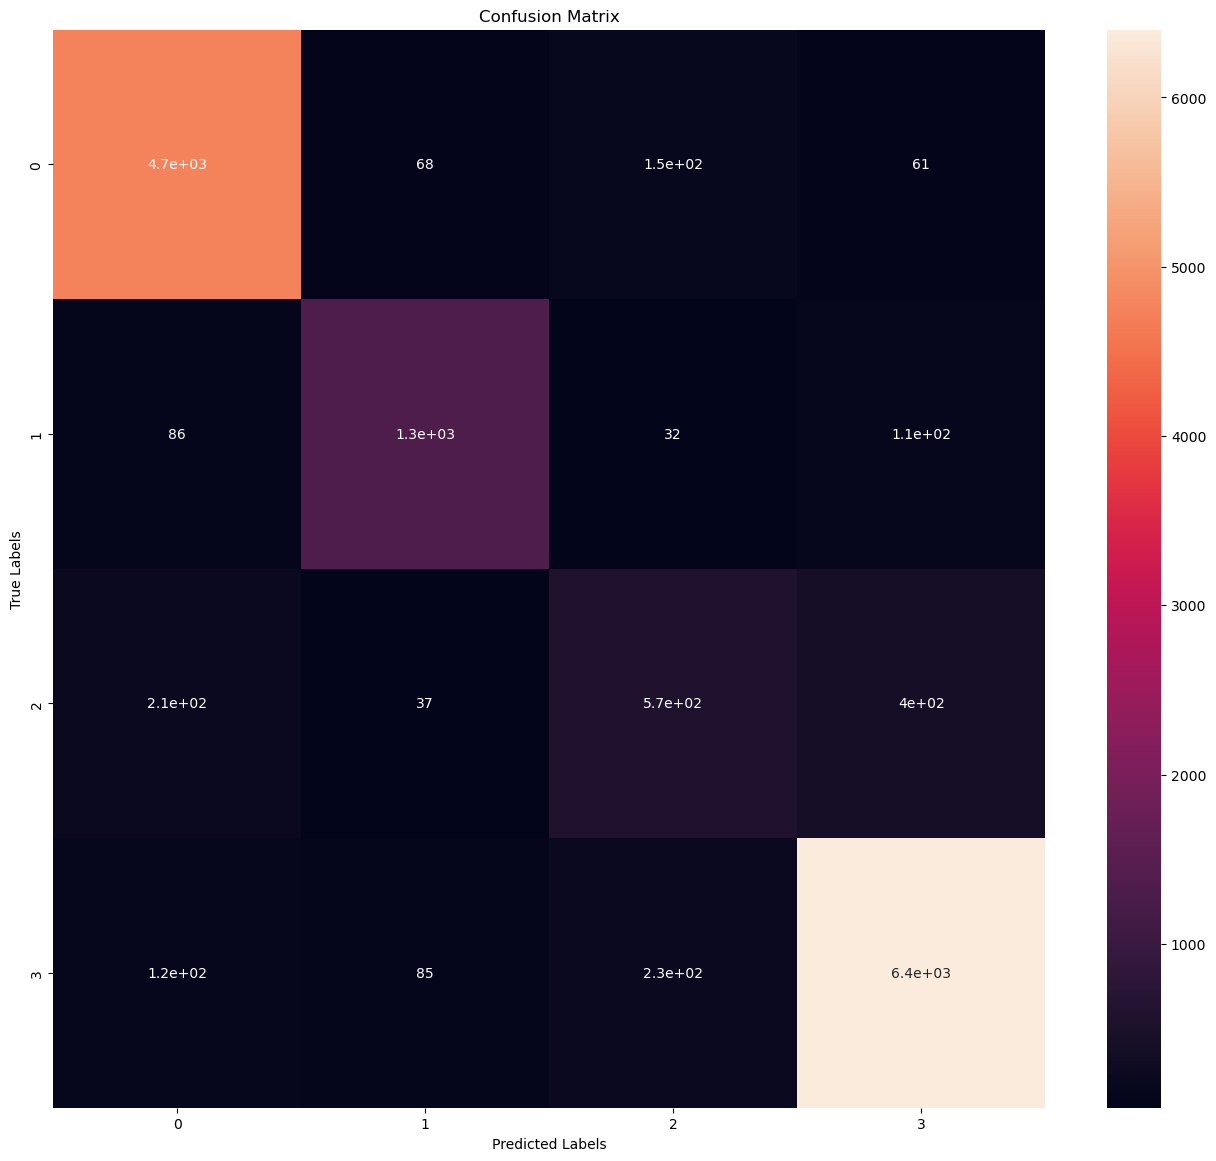

In [12]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 10)
print_losses_plot(train_losses, val_losses, test_average_loss, 10)
print_confusion_matrix(total_correct_pred, test_pred)


In [13]:
# L2 Regularization
regularization_model = cnn()
regularization_model.to(device)
optimizer_l2 = optim.Adam(regularization_model.parameters(), lr=0.001, weight_decay=0.000001)
train_losses, val_losses, train_accuracies, val_accuracies = train(regularization_model, train_loader, val_loader, criterion, optimizer_l2, epochs=10)
test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)
        outputs = regularization_model(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item()

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_mat = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_mat)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Epoch 1/10, Training Loss: 0.6662, Validation Loss: 0.4773
Train Accuracy: 75.92806999545674	Validation Accuracy: 83.28431707817522
Epoch 2/10, Training Loss: 0.4476, Validation Loss: 0.4185
Train Accuracy: 84.34188735655768	Validation Accuracy: 85.42507352438274
Epoch 3/10, Training Loss: 0.3829, Validation Loss: 0.3763
Train Accuracy: 86.56954845895682	Validation Accuracy: 86.6698584228165
Epoch 4/10, Training Loss: 0.3429, Validation Loss: 0.3450
Train Accuracy: 87.89002388873419	Validation Accuracy: 87.8325695916832
Epoch 5/10, Training Loss: 0.3133, Validation Loss: 0.3307
Train Accuracy: 88.92178271510852	Validation Accuracy: 88.461801518364
Epoch 6/10, Training Loss: 0.2844, Validation Loss: 0.3174
Train Accuracy: 89.93155804376181	Validation Accuracy: 88.81061486902401
Epoch 7/10, Training Loss: 0.2566, Validation Loss: 0.3003
Train Accuracy: 90.98969706740141	Validation Accuracy: 89.64503111962246
Epoch 8/10, Training Loss: 0.2313, Validation Loss: 0.2961
Train Accuracy: 91.91

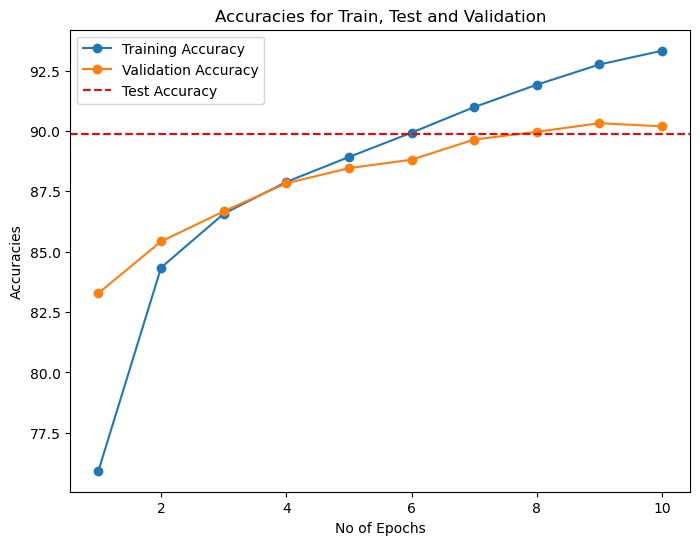

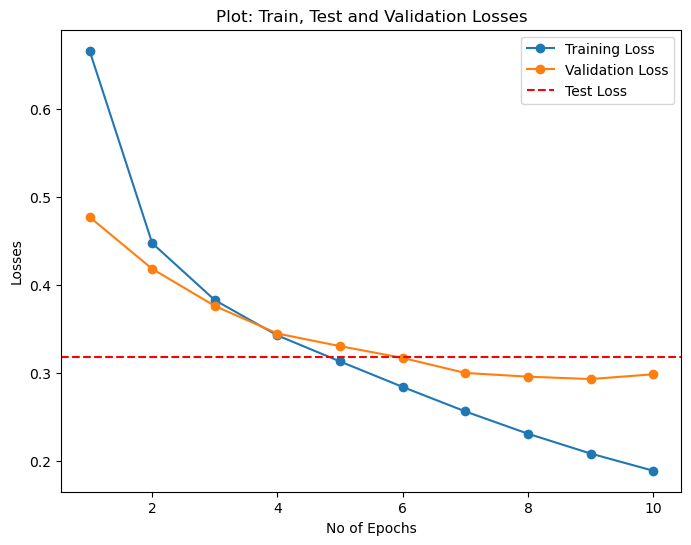

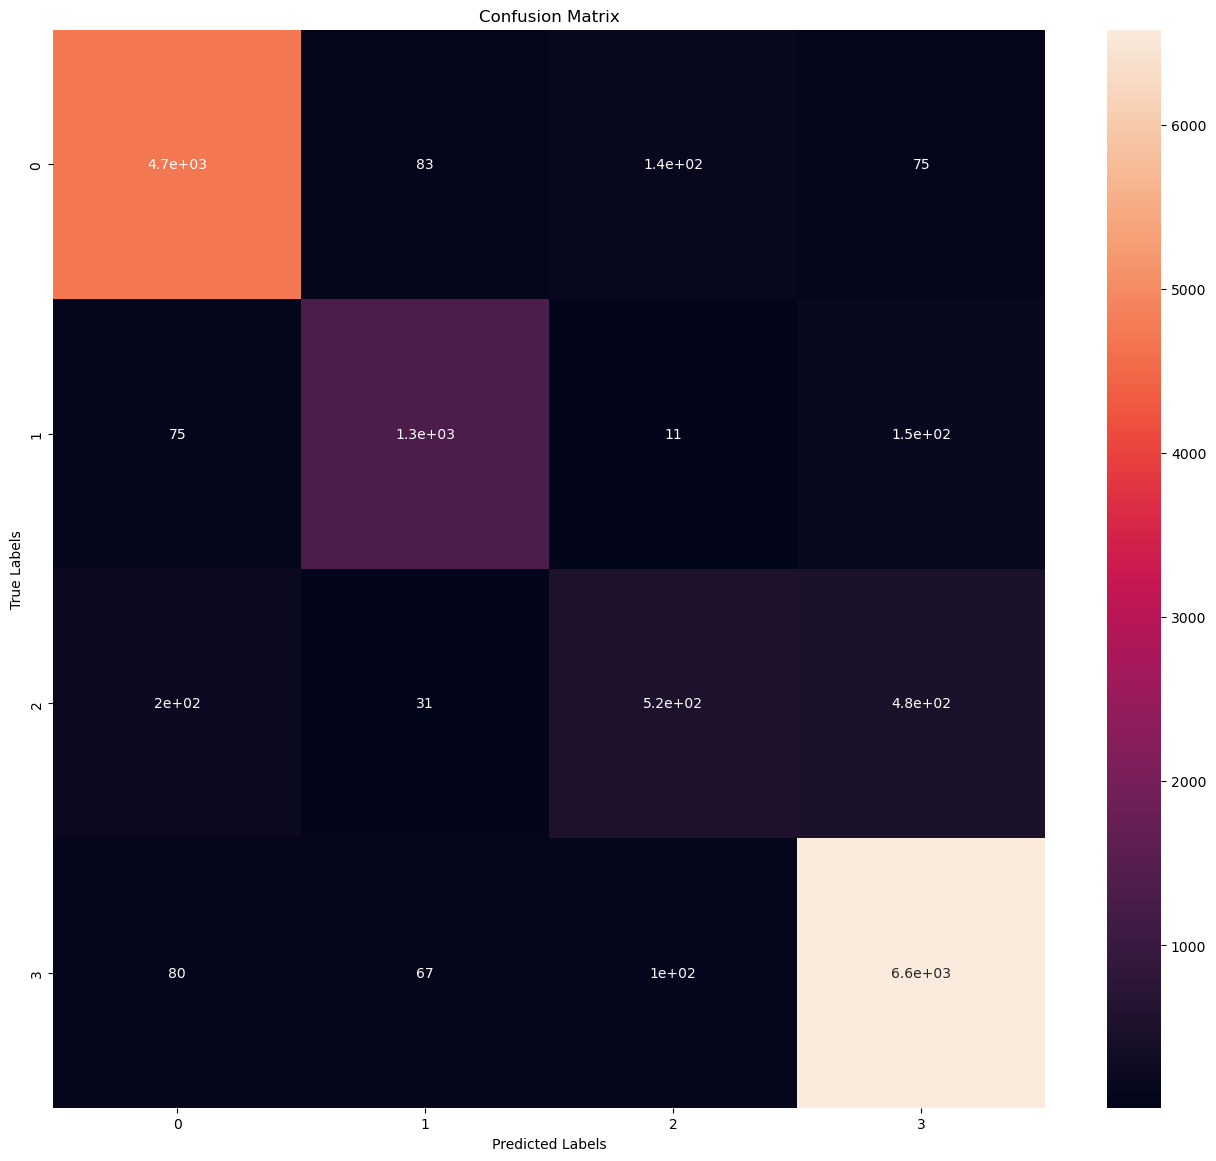

In [14]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 10)
print_losses_plot(train_losses, val_losses, test_average_loss, 10)
print_confusion_matrix(total_correct_pred, test_pred)

In [15]:
# Dropout

class cnndrop(nn.Module):
    def __init__(self):
        super(cnndrop, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
    def summary(self):
        return summary(model)
    
    
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
drop_model = cnndrop()
drop_model.to(device)
print(drop_model.summary())

criterion = nn.CrossEntropyLoss()
optimizer_drop = optim.Adam(drop_model.parameters(), lr=0.001)

train_losses, val_losses, train_accuracies, val_accuracies = train(drop_model, train_loader, val_loader, criterion, optimizer_drop, epochs=10)

test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)
        outputs = drop_model(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item()

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_mat = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_mat)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Layer (type:depth-idx)                   Param #
cnn                                      --
├─Conv2d: 1-1                            320
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Linear: 1-4                            803,072
├─Linear: 1-5                            32,896
├─Linear: 1-6                            516
Total params: 855,300
Trainable params: 855,300
Non-trainable params: 0
Epoch 1/10, Training Loss: 0.6932, Validation Loss: 0.4731
Train Accuracy: 74.70578752216669	Validation Accuracy: 83.72204363586621
Epoch 2/10, Training Loss: 0.4661, Validation Loss: 0.4062
Train Accuracy: 83.95644336318203	Validation Accuracy: 85.54818411873333
Epoch 3/10, Training Loss: 0.4116, Validation Loss: 0.3597
Train Accuracy: 85.89099116263391	Validation Accuracy: 87.36748512413652
Epoch 4/10, Training Loss: 0.3793, Validation Loss: 0.3701
Train Accuracy: 86.89930092477248	Validation Accuracy: 87.33328773681691
Epoch 5/10, Training Loss: 0

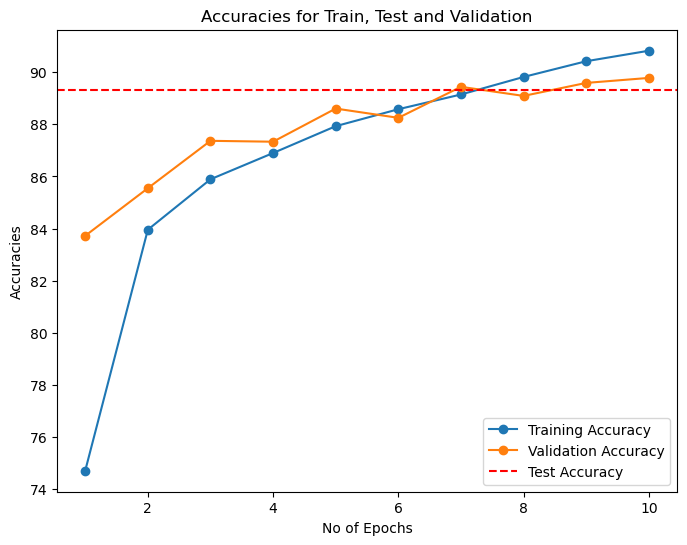

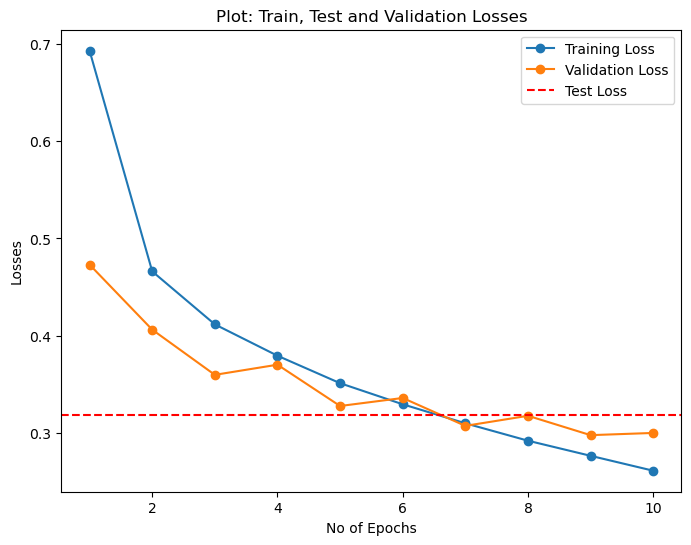

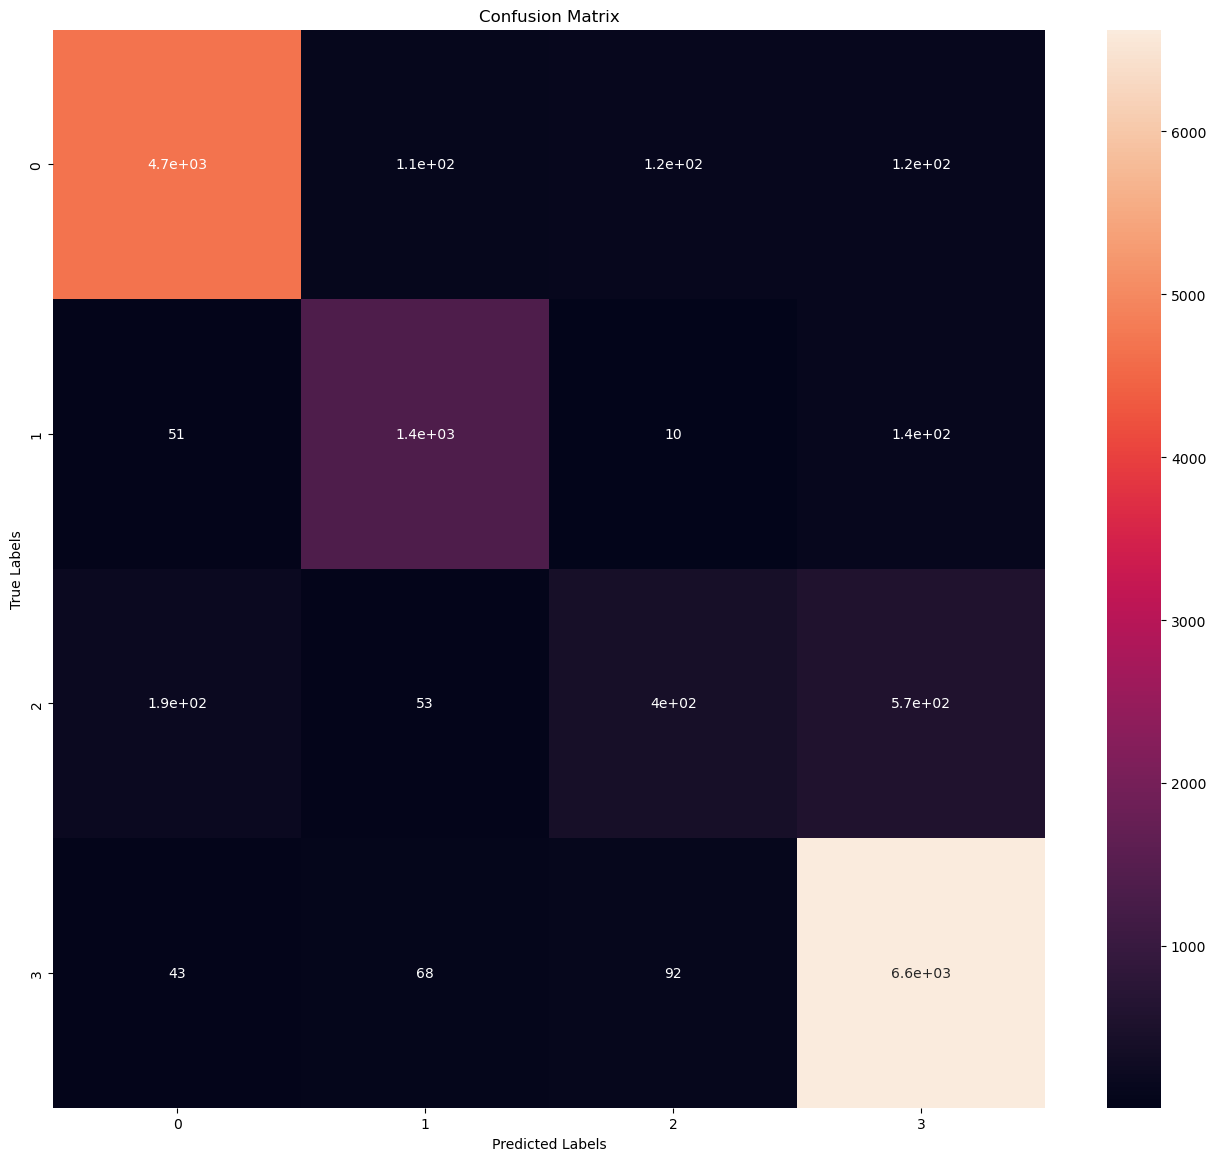

In [16]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 10)
print_losses_plot(train_losses, val_losses, test_average_loss, 10)
print_confusion_matrix(total_correct_pred, test_pred)

In [17]:
# Early stopping

def earlystop_train(model, train_loader, val_loader, criterion, optimizer, epochs=2):
    best_val_accuracy = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        correct_val = 0
        total_train = 0
        total_val = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy =  100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        # Validation loss
        model.eval()
        val_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze(1)
            outputs = model(inputs)
            _, predicted_val = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy =  100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy 
            torch.save(model.state_dict(), 'best_early_model.pth')

        
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy}\tValidation Accuracy: {val_accuracy}')
    return train_losses, val_losses, train_accuracies, val_accuracies

early_model = cnn()
early_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_early = optim.Adam(early_model.parameters(), lr=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = earlystop_train(early_model, train_loader, val_loader, criterion, optimizer_early, epochs=10)
best_early_model = cnn()
best_early_model.load_state_dict(torch.load('best_early_model.pth'))
best_early_model.to(device)

test_pred = []
total_correct_pred = []
total_test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)
        outputs = best_early_model(inputs)
        _,pred = torch.max(outputs, 1)
        test_pred.extend(pred.cpu().numpy())
        total_correct_pred.extend(labels.cpu().numpy())
        test_loss =  criterion(outputs, labels)
        total_test_loss += test_loss.item() 

test_average_loss = total_test_loss / len(test_loader)
precision = precision_score(total_correct_pred, test_pred, average='macro')
recall = recall_score(total_correct_pred, test_pred, average='macro')
f1 = f1_score(total_correct_pred, test_pred, average='macro')
conf_mat = confusion_matrix(total_correct_pred, test_pred)
accuracy = accuracy_score(total_correct_pred, test_pred)

print("Accuracy: ", accuracy * 100)
print("Confusion Matrix: ", conf_mat)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F1 Score: ", f1*100)

Epoch 1/10, Training Loss: 0.7026, Validation Loss: 0.5035
Train Accuracy: 74.32767136136474	Validation Accuracy: 82.22419807126735
Epoch 2/10, Training Loss: 0.4740, Validation Loss: 0.4675
Train Accuracy: 83.44789178256855	Validation Accuracy: 83.74256206825798
Epoch 3/10, Training Loss: 0.4067, Validation Loss: 0.3778
Train Accuracy: 85.7048642152624	Validation Accuracy: 86.84084535941454
Epoch 4/10, Training Loss: 0.3630, Validation Loss: 0.3563
Train Accuracy: 87.29207275072179	Validation Accuracy: 87.27173243964161
Epoch 5/10, Training Loss: 0.3318, Validation Loss: 0.3468
Train Accuracy: 88.30184807937508	Validation Accuracy: 87.79153272689966
Epoch 6/10, Training Loss: 0.3055, Validation Loss: 0.3222
Train Accuracy: 89.28231207773365	Validation Accuracy: 88.98844128308598
Epoch 7/10, Training Loss: 0.2807, Validation Loss: 0.3076
Train Accuracy: 90.10302932598596	Validation Accuracy: 89.46720470556049
Epoch 8/10, Training Loss: 0.2546, Validation Loss: 0.3198
Train Accuracy: 91

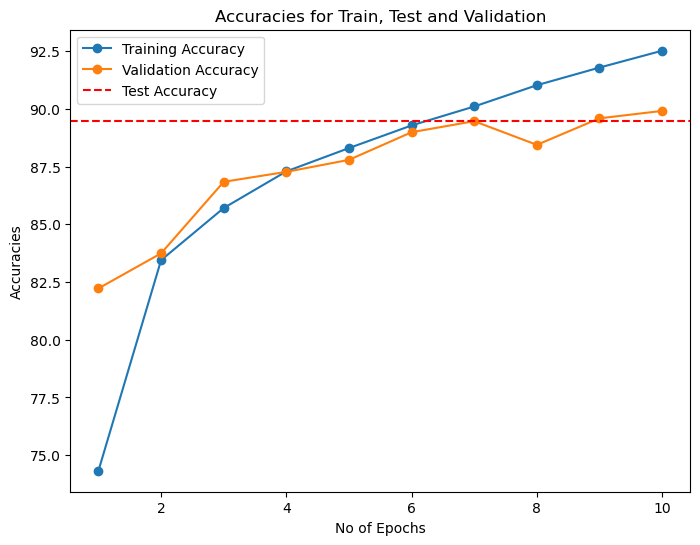

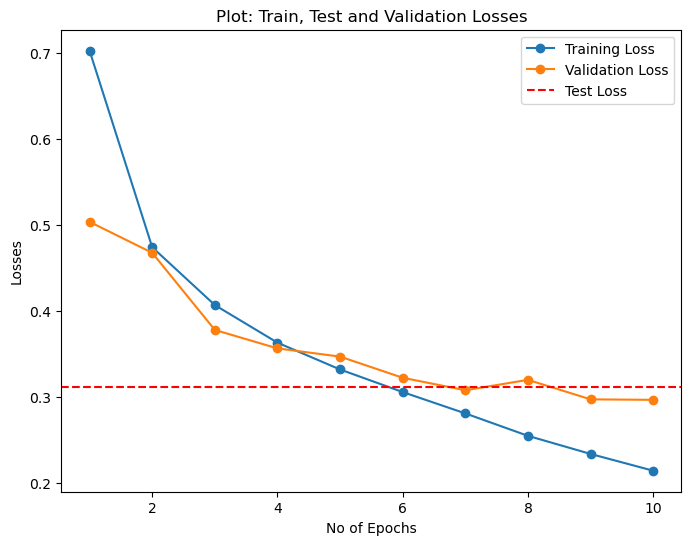

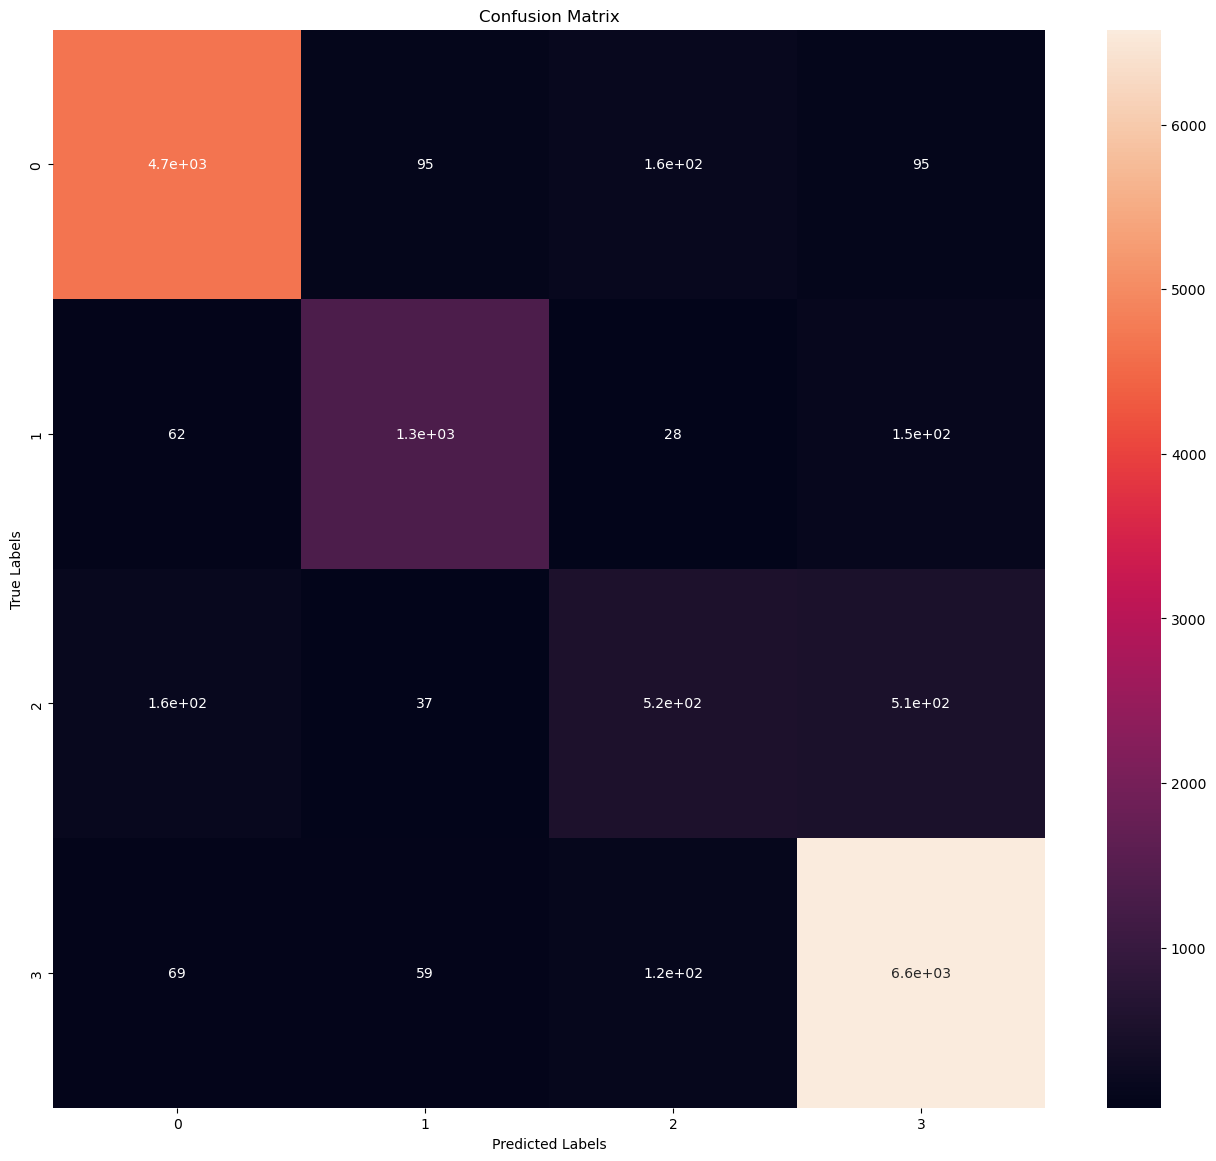

In [18]:
print_accuracy_plot(train_accuracies, val_accuracies, accuracy*100, 10)
print_losses_plot(train_losses, val_losses, test_average_loss, 10)
print_confusion_matrix(total_correct_pred, test_pred)

In [19]:

torch.save(regularization_model.state_dict(), 'cnara_assignment0_part3.h5')
